# Logistic Regression, Bayes and EM

## We will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

In [7]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [10]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values



## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

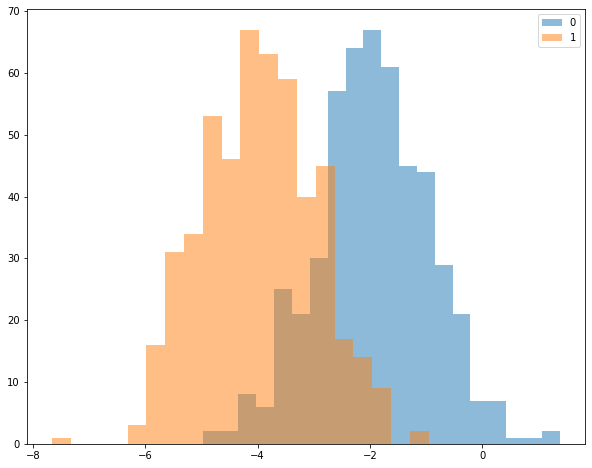

In [11]:
#### Your code here ####
train = training_set.values

train_first_1k_0 = train[:1000][train[:1000][:,-1] == 0]
train_first_1k_1 = train[:1000][train[:1000][:,-1] == 1]

train_0 = train[train[:,-1] == 0]
train_1 = train[train[:,-1] == 1]


plt.hist(train_first_1k_0[:,0], bins=20, alpha=0.5, label= "0")
plt.hist(train_first_1k_1[:,0], bins=20, alpha=0.5, label= "1")
plt.legend()
plt.show()

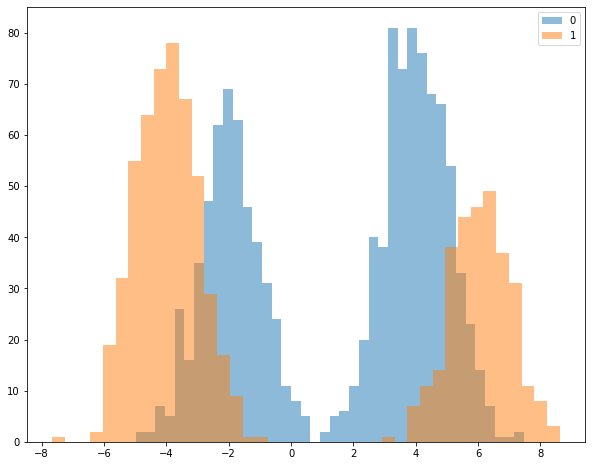

In [15]:
plt.hist(train_0[:,0], bins=40, alpha=0.5, label="0")
plt.hist(train_1[:,0], bins=40, alpha=0.5, label="1")
plt.legend()
plt.show()

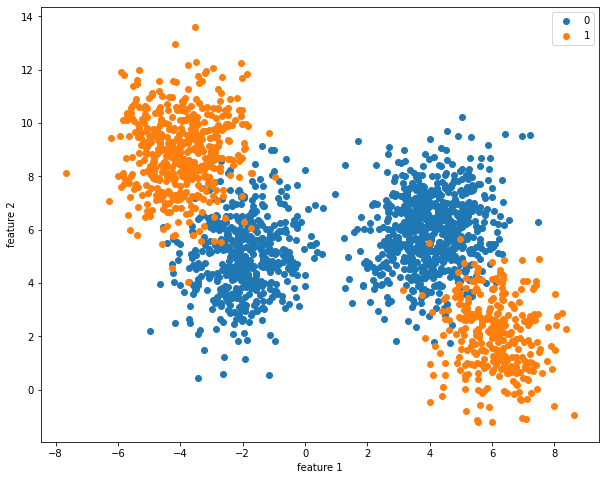

In [16]:
plt.scatter(train_0[:,0], train_0[:,1], label ="0");
plt.scatter(train_1[:,0], train_1[:,1], label ="1");
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

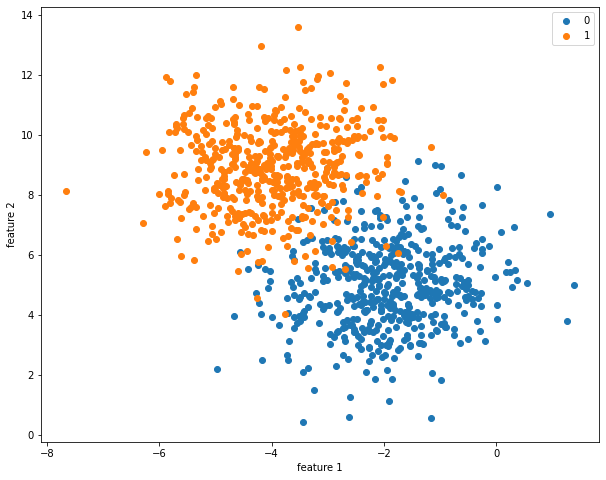

In [17]:
plt.scatter(train_first_1k_0[:,0], train_first_1k_0[:,1], label ="0");
plt.scatter(train_first_1k_1[:,0], train_first_1k_1[:,1], label ="1");
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## Logistic Regression



Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Our model should  store a list of the costs that we've calculated in each iteration

In [18]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.J_history = []

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        X = np.column_stack((np.ones(X.shape[0]), X))
        
        
        seed = self.random_state
        np.random.seed(seed)
        theta = np.random.random(X.shape[1])
        
        for i in range(self.n_iter):
            h = 1 / (1 + np.exp(np.dot(X, -theta.T))) 
            loss = h - y
            gradient = (self.eta * np.dot(loss, X)/ X.shape[0])
            theta = theta - gradient
            
            cost = self.compute_cost(X,y,theta) 
            self.J_history.append(cost)
            
            if len(self.J_history) > 1 and np.abs(self.J_history[-1] - self.J_history[-2]) < self.eps:
                self.theta = theta
                return
                
        self.theta = theta 
        
    def predict(self, X):
        """Return the predicted class label"""
        X = np.hstack((np.ones((X.shape[0], 1)),X))
        
        h = 1 / (1 + np.exp(np.dot(X, -self.theta.T)))
        
        return np.around(h)

    def compute_cost(self, X, y, theta):
        m = X.shape[0]
        h = 1 / (1 + np.exp(np.dot(X, -theta.T)))
        J = np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
        
        return J / m
        
    def compute_accuracy(self, X, y): 
        accuracy = 0
        for i in range(y.shape[0]):
            if X[i]==y[i]:
                accuracy += 1 
                
        return accuracy / y.shape[0]

## Cross Validation

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

In [19]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

data = training_set.values
np.random.shuffle(data)

data = np.split(data, 5)

best_eta = 0
best_eps = 0
best_accuracy = 0

for eta in etas:
    for eps in epss:
        accuracy = 0
        for i in range(5):
            train = np.concatenate((data[:i] + data[i + 1:]), axis=0)
            test =  data[i]
            
            lrgd = LogisticRegressionGD(eta=eta, n_iter=10000, eps=eps, random_state=1)
            lrgd.fit(train[:, :-1], train[:, -1])
            predictions = lrgd.predict(test[:, :-1])
            
            accuracy += lrgd.compute_accuracy(predictions, test[:,-1])
            
        accuracy /= 5
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_eps = eps
            best_eta = eta

print(f"The best (eta, eps) = ({best_eta}, {best_eps})")

The best (eta, eps) = (0.05, 1e-06)
0.788


## Normal distribution pdf

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [20]:
def norm_pdf(data, mu, sigma):
    return (1 / (np.dot(sigma, np.sqrt(2 * np.pi)))) * np.exp(-0.5 * (((data - mu) / sigma) ** 2))

## Expectation Maximization


Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian.


Don't change the eps params (eps=0.01)

In [21]:
class EM(object):
    """
    Naive Bayes Classifier using Gausian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps    
        self.w = [0] * k
        self.mu = [0] * k
        self.sigma = [0] * k
        self.res = [] 
        self.J_history = []
  
        
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        self.w = np.ones(self.k) / self.k   
        partition = np.array_split(data, self.k)
        for i in range(self.k):
            self.sigma[i] = np.std(partition[i])
            self.mu[i] = np.mean(partition[i]) 
            
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        responsibility = self.w[0] * norm_pdf(data, self.mu[0], self.sigma[0])
        for i in range(1, self.k):
            responsibility = np.column_stack((responsibility, self.w[i] * norm_pdf(data, self.mu[i], self.sigma[i])))

        denominator = np.sum(responsibility, axis=1).reshape(-1,1)
        self.res = responsibility / denominator


    def maximization(self, data):
        """
        M step - updating distribution params
        """
        self.w = np.sum(self.res, axis=0) / data.shape[0]
        self.mu = np.dot(self.res.T, data) / (self.w * data.shape[0])
        
        for i in range(self.k):
            self.sigma[i] = np.sqrt(np.sum(np.dot(self.res[:,i], (data - self.mu[i]) ** 2)) / (self.w[i] * data.shape[0]))
            

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        
        self.init_params(data)
        
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            J = self.compute_cost(data)
            self.J_history.append(J)
            
            if len(self.J_history) > 1 and np.abs(self.J_history[-1] - self.J_history[-2]) < self.eps:
                return
                
    def get_dist_params(self):
        return self.w, self.mu, self.sigma
    
    def compute_cost(self, data):
        J = 0
        for k in range(self.k):
            J -= np.log(np.dot(norm_pdf(data, self.mu[k], self.sigma[k]), self.w[k]))
            
        return np.sum(J)

## Naive Bayes


Implement the Naive Bayes algorithm.

For calculating the likelihood we'll use the EM algorithm that we implemented above to find the distribution params. With these params we can calculate the likelihood probability.

We'll calculate the prior probability directly from the training set.

In [22]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.gaussian = []
        self.prior = 0
    
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        
        data = np.column_stack((X, y))
        class_counts = np.unique(y, return_counts=True)[1]
        self.prior = class_counts / len(y)
        gaussian = np.zeros((len(class_counts), X.shape[1], 3, self.k))
        
        for i in range(len(class_counts)):
            for j in range(X.shape[1]):
                em = EM(k=self.k)
                train = data[data[:,-1] == i][:,j]
                em.fit(train)
                gaussian[i][j] = em.get_dist_params()
        self.gaussian = gaussian
    
    def predict(self, X):
        """Return the predicted class label"""
        prob = []
        classes = []
        
        for i in range(self.k):
            for j in range(X.shape[1]): 
                llh = 0
                for k in range(self.k):
                    
                    llh += self.gaussian[i][j][0][k] * norm_pdf(X[:,j], self.gaussian[i][j][1][k], 
                                                               self.gaussian[i][j][2][k])      
                prob.append(llh)

        classes.append(prob[0] * prob[1] * self.prior[0])
        classes.append(prob[2] * prob[3] * self.prior[1])

        predict_X = np.ones((X.shape[0]))
        
        for i in range(X.shape[0]):
            if classes[1][i] <= classes[0][i]:
                predict_X[i] = 0
                
        return predict_X
    
    
    def compute_accuracy(self, X, y):
        """Returns the accuracy of the prediction"""
        accuracy = 0
        
        for i in range(X.shape[0]):
            if X[i] == y[i]:
                accuracy += 1
                
        return accuracy / y.shape[0]

## Model evaluation


In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.



In [31]:
training_1000 = training_set[:1000].values
X_train_1000 = training_1000[:, :-1]
y_train_1000 = training_1000[:,-1]

testing_500 = test_set[:500].values
X_test_500 = testing_500[:, :-1]
y_test_500 = testing_500[:,-1]

lrgd = LogisticRegressionGD(eta=best_eta, n_iter=10000, eps=best_eps, random_state=1)
lrgd.fit(X_train_1000, y_train_1000)
predictions = lrgd.predict(X_train_1000)
accuracy = lrgd.compute_accuracy(predictions, y_train_1000)
print(f"With 1000 data points Logistic Regression accuracy = {accuracy}")

predictions = lrgd.predict(X_test_500)
accuracy = lrgd.compute_accuracy(predictions, y_test_500)
print(f"With 500 data points Logistic Regression, accuracy = {accuracy}")

nbg = NaiveBayesGaussian(k=2)
nbg.fit(X_train_1000, y_train_1000)
prediction = nbg.predict(X_train_1000)
accuracy = nbg.compute_accuracy(prediction, y_train_1000)
print(f"With 1000 data points Naive Bayes Classifier using Gauusian Mixture Model, accuracy = {accuracy}")

prediction = nbg.predict(X_test_500)
accuracy = nbg.compute_accuracy(prediction, y_test_500)
print(f"With 500 data points Naive Bayes Classifier using Gauusian Mixture Model accuracy, accuracy = {accuracy}")

With 1000 data points Logistic Regression accuracy = 0.965
With 500 data points Logistic Regression, accuracy = 0.938
With 1000 data points Naive Bayes Classifier using Gauusian Mixture Model, accuracy = 0.968
With 500 data points Naive Bayes Classifier using Gauusian Mixture Model accuracy, accuracy = 0.942


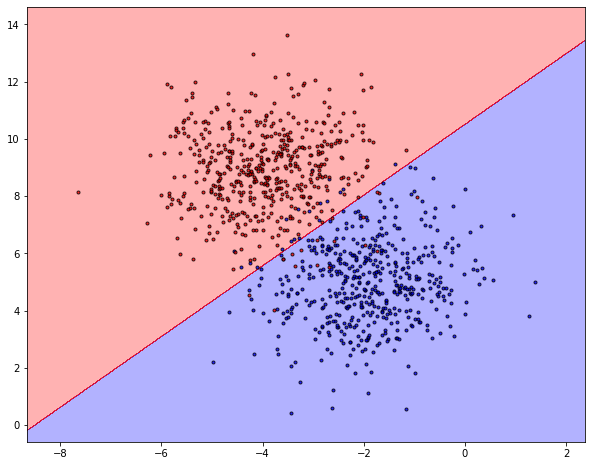

In [32]:
plot_decision_regions(X_train_1000, y_train_1000, classifier=lrgd)

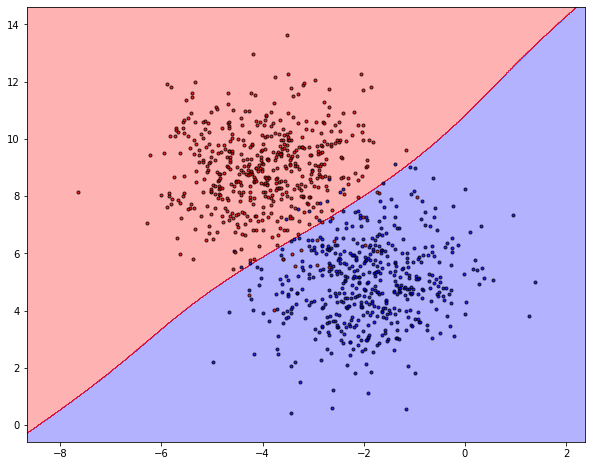

In [33]:
plot_decision_regions(X_train_1000, y_train_1000, classifier=nbg)

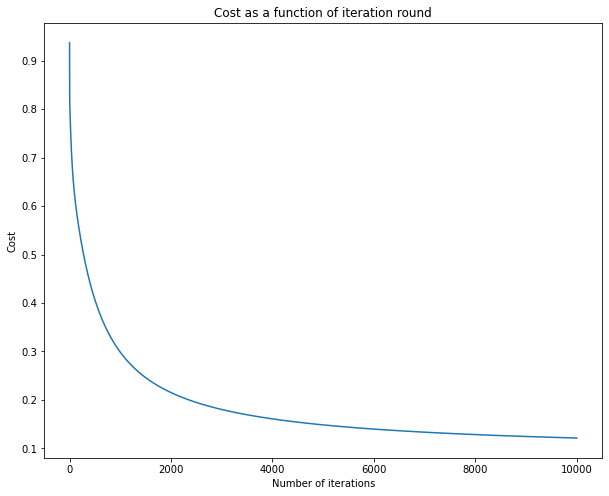

In [34]:
plt.plot(np.arange(len(lrgd.J_history)), lrgd.J_history)
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost as a function of iteration round')
plt.show()
